### Topic 
For my project, I created a sentiment analysis model trained on twitter data to determine if a tweet has a positive or negative sentiment. While there are numerous advantages to doing this like analysis of customer feedback, gathering marketing data, and determining public opinion, my primary interest would be in using this for gathering stock/cryptocurrency market sentiment since especially with young investors, online sentiment and hype can be a driving factor in price action.

### Dataset 
I used the "Sentiment140" dataset with 1.6 million tweets. The dataset is available from a variety of sources but I used the version available on [Kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140).


The dataset contains the following fields:
- target: the sentiment value (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet (2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (NO_QUERY if it doesn't exist)
- user: the user who posted the tweet
- text: the tweet's text content

However, for the purposes of my model the id, data, flag, and user fields are not needed. Instead only the target and test fields are extracted. Additionally, while the documentation for the dataset mentions that 2 is neutral, when looking at the actual content of the dataset, every version of it that I saw actually didn't contain any neutral tweets so they aren't considered either. Lastly, since I felt that 4 was an odd value for readability, I change all 4s to 1s.

For this project I have the original dataset downloaded and stored at "twitter/twitterData.csv"

### Dataset Analysis 
The first step to take is loading in the dataset and performing some basic analysis on it. First we will do some basic precautionary checks like validating the column count, checking for null values, examining the length, etc. Then we will first check the balance of classes positive vs negative and consider whether techniques like oversampling or under sampling will be needed. 

Column count matches. Columns:  Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
No null values found. Check passed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None
Class counts:  target
0    800000
4    800000
Name: count, dtype: int64


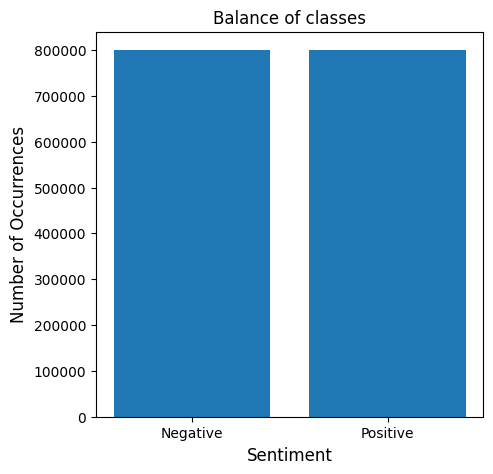

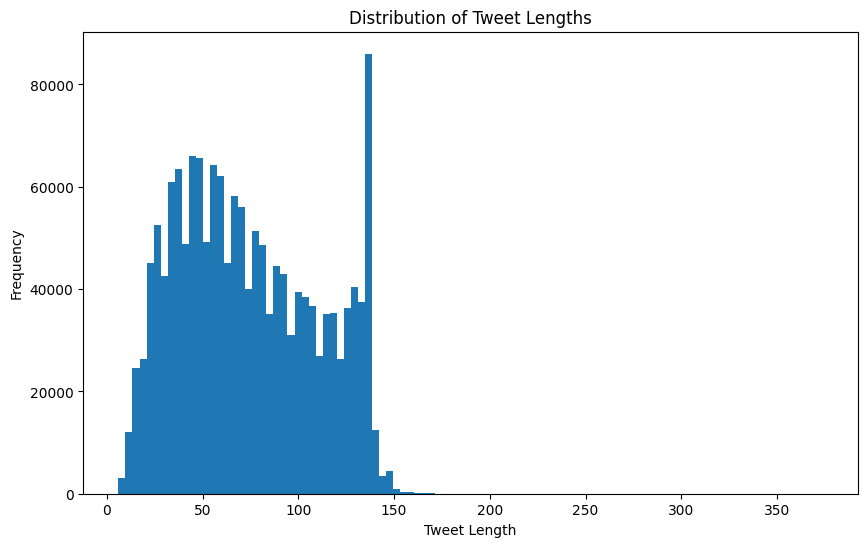

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

original_twitter_file = 'twitter/twitterData.csv'
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
twitterData = pd.read_csv(original_twitter_file, names=column_names, header=None, encoding='ISO-8859-1')

if len(twitterData.columns) != len(column_names):
    print("Error: Column count mismatch")
else:
    print("Column count matches. Columns: ", twitterData.columns)

if twitterData.isnull().values.any():
    print("Error: Null values found")
else:
    print("No null values found. Check passed")

print(twitterData.info())

# Determine the balance of classes 
class_counts = twitterData['target'].value_counts()

print("Class counts: ", class_counts)

# Plot balance
plt.figure(figsize=(5,5))
plt.bar(class_counts.index.astype(str), class_counts.values)

plt.title('Balance of classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)

plt.show()


# Create a new column in the dataframe that holds the text length
twitterData['text_length'] = twitterData['text'].apply(len)

# Tweet length distribution plot
plt.figure(figsize=(10,6))
twitterData['text_length'].plot.hist(bins=100)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

plt.show()



### Preprocess Text
The next step is to preprocess the text. This was quite an involved process to learn and implement, but I believe I now have a decent solution. The first step I took was to change the positive values from 4 to 1 since the dataset is binary and it just makes more sense to have 0 be negative and 1 be positive. From there, we move on to cleaning the individual text. 

### Text Cleaning
The text cleaning step converts all text to lowercase, removes unnecessary/noisy data like punctuation, stopwords, repeating letters, urls and twitter specific data like @mentions and #hashtags. Thankfully, nltk provides a lot of useful tools for making this much easier, and regex alongside python's built in string functionality can be used to finish the rest

In [42]:
import re
import string
import nltk
from nltk.corpus import stopwords


nltk.download('punkt')
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))


def clean_text(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove stopwords
    tweet = clean_stop_words(tweet)

    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Remove repeating letters
    tweet = clean_repeat_letters(tweet)

    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)

    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'@[a-zA-Z0-9_]+|#[a-zA-Z0-9_]+', '', tweet)

    # Remove numbers/numeric data
    tweet = re.sub(r'\d+', '', tweet)

    return tweet


def clean_stop_words(tweet):
    return " ".join([word for word in str(tweet).split() if word not in stop_words])


def clean_repeat_letters(tweet):
    return re.sub(r'(.)\1+', r'\1\1', tweet)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preprocess Text Continued
After performing the text cleaning, we use nltk again to perform tokenization, stemming, and lemmatization. Tokenization is the process of splitting the text into individual words. Stemming is the process of reducing words to their root form. Lemmatization is the process of reducing words to their dictionary form. For example, the words "running", "ran", and "runs" would all be reduced to "run". This is a very important step because it reduces the number of unique words in the dataset and helps maintain the underlying patterns of the data. 

Since the dataset is so massive and this step can take quite a bit of time, I use tqdm to display the progress while it runs and added some extra functionality for saving the processed data in a new file so that I don't have to run this step every time I want to train the model, and can iterate on development much faster. 

In [43]:
import pandas as pd
import text_cleaning
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk

tqdm.pandas()
nltk.download('wordnet')
tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def load_processed_data(cleaned_twitter_file):
    data = pd.read_csv(cleaned_twitter_file)
    data['text'] = data['text'].apply(lambda x: ' '.join(eval(x)))
    return data


def preprocess_data(original_twitter_file, cleaned_twitter_file=None):
    column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
    twitterData = pd.read_csv(original_twitter_file, names=column_names, header=None, encoding='ISO-8859-1')
    data = twitterData[['text', 'target']]
    data.loc[data['target'] == 4, 'target'] = 1
    data_positive = data[data['target'] == 1]
    data_negative = data[data['target'] == 0]

    dataset = pd.concat([data_positive, data_negative])

    print("Cleaning data...")
    dataset['text'] = dataset['text'].progress_apply(text_cleaning.clean_text)
    print("Cleaned data")

    print("Tokenizing data")
    dataset['text'] = dataset['text'].progress_apply(tokenizer.tokenize)

    print("Stemming data")
    dataset['text'] = dataset['text'].progress_apply(stem_words)

    print("Lemmatizing data")
    dataset['text'] = dataset['text'].progress_apply(lemmatize_words)

    if cleaned_twitter_file:
        dataset.to_csv(cleaned_twitter_file, index=False)

    return dataset


def stem_words(words):
    return [stemmer.stem(word) for word in words]


def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\perso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Preprocessing Final
Putting it all together, we will now read in the data from the original file, preprocess it, and then save the prepared data to a separate file that can simply be read from in the future whenever we want to retrain the model. Simply change the bool value to change what functionality is run. For the first time running it the value should be set to true, setting it to false speeds up the process significantly for future runs.

In [44]:
do_preprocess_step = True
original_twitter_file = 'twitter/twitterData.csv'
cleaned_twitter_file = 'twitter/twitterDataCleaned.csv'

if do_preprocess_step:
    preprocess_data(original_twitter_file, cleaned_twitter_file)


dataset = load_processed_data(cleaned_twitter_file)
    


Cleaning data...


100%|██████████| 1600000/1600000 [00:16<00:00, 98292.98it/s] 


Cleaned data
Tokenizing data


100%|██████████| 1600000/1600000 [00:08<00:00, 197426.25it/s]


Stemming data


100%|██████████| 1600000/1600000 [01:31<00:00, 17472.33it/s]


Lemmatizing data


100%|██████████| 1600000/1600000 [00:25<00:00, 63129.55it/s]


### Splitting The Data and feature extraction
Now that the data is prepared, we can split it into training and testing data. I chose to use 95% of the data for training and 5% for testing. 

Originally, I was planning to use a combination of the Bag of Words method (most frequently used words) and TF-IDF together, using the Bag of Words value as a flag to determine it's presence and weighting that against the TF-IDF value but I found that lead to increasing signs of overfitting so I ended up just using TF-IDF on it's own. 


### Hyperparameter Tuning
The next step is to tune the hyperparameters of the model, to keep the code clean and condensed, I decide to make use of sklearn's pipeline functionality which ended up being very nice and clean to work with after learning how to use it. I tried using GridSearchCV but it took way too long to run so I had to switch to RandomizedSearchCV instead which still takes very long but is much more manageable. Due to the sheer length of time it takes to run I had to reduce the amount of iterations, parameters in the param_grid etc to be able to iterate on the project but for a real world example I would definitely have a more robust setup and would look into using a cloud service to run the hyperparameter tuning on.

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

X = dataset['text'].apply(''.join)
y = dataset['target']

print("Splitting data")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=26105111)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=26105111)



print("Split data")

pipeline = Pipeline([
    ('vectoriser', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, n_jobs=-1))
])

param_grid = {
    'classifier__C': np.logspace(-3, 3, 20),
    'vectoriser__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vectoriser__max_features': [200000, 500000, 750000]
}

n_iter_search = 10 
print("Beginning randomized search")

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, scoring='accuracy', cv=2, verbose=2, n_iter=n_iter_search, n_jobs=-1)

print("Finished random search")

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

best_C = random_search.best_params_['classifier__C']
best_ngram_range = random_search.best_params_['vectoriser__ngram_range']
best_max_features = random_search.best_params_['vectoriser__max_features']



Splitting data
Split data
Beginning randomized search
Finished random search
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters found:  {'vectoriser__ngram_range': (1, 3), 'vectoriser__max_features': 500000, 'classifier__C': 1.438449888287663}
Best score found:  0.7911491228070175


### Hyperparameter Results
While I can't realistically do more tuning since even just the fairly simple model I have now takes about 15 minutes on my machine each time I run it, the following code can still be used to visualize the results of the hyperparameter tuning.

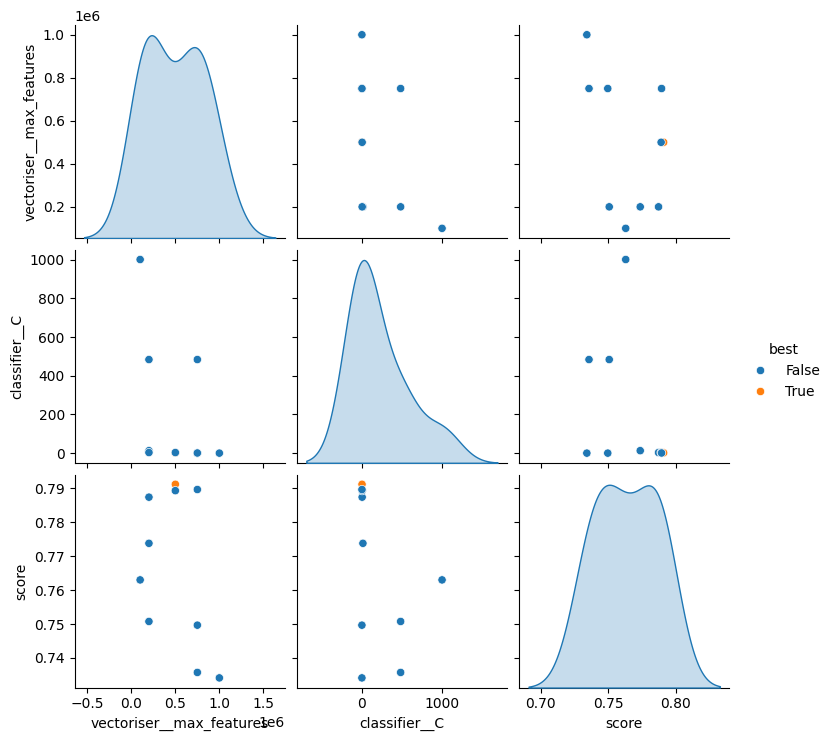

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
mean_test_scores = random_search.cv_results_['mean_test_score']
std_test_scores = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']

results = pd.DataFrame(params)
results['score'] = mean_test_scores

results['best'] = results['score'] == results['score'].max()

# Colored by the 'best' column
sns.pairplot(results, hue='best')
plt.show()

### Final Model
Now that the hyperparameter tuning is complete, we can use the best parameters to train the final model and then get our results with the test and validation data. I tried out a few different models during development including Logistic Regression, SVM, and Naive Bayes. However ultimately I found Logistic Regression to be the best performing model in this situation that also had very reasonable training times. I would've liked to include the max_iter parameter in the hyperparameter tuning but I had to leave it out and just go with a constant value as the process already takes a very long time to run.

Best c:  1.438449888287663
Best ngram range:  (1, 3)
Best max features:  500000
Train Accuracy:  0.8457463450292397
Validation Accuracy:  0.797875


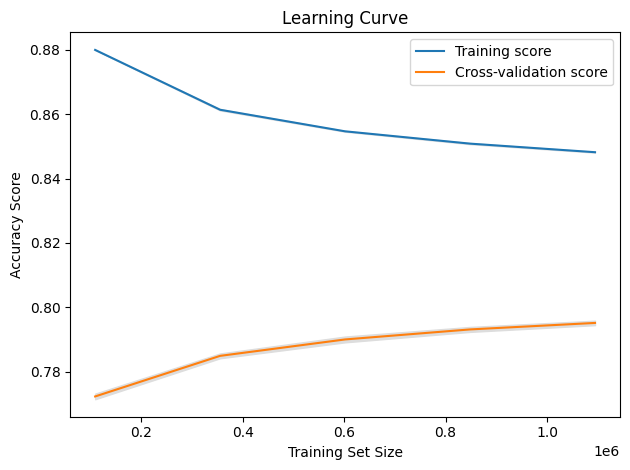

Test Accuracy:  0.7959875


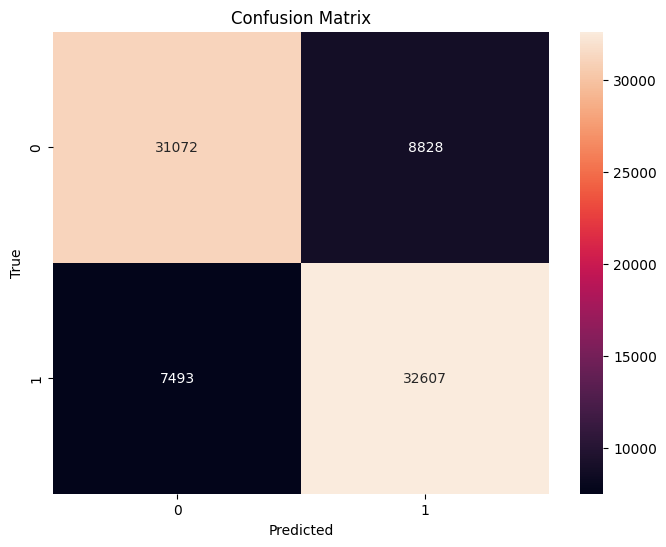

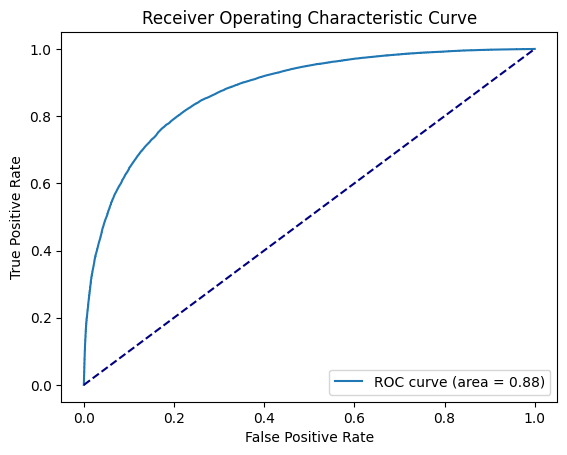

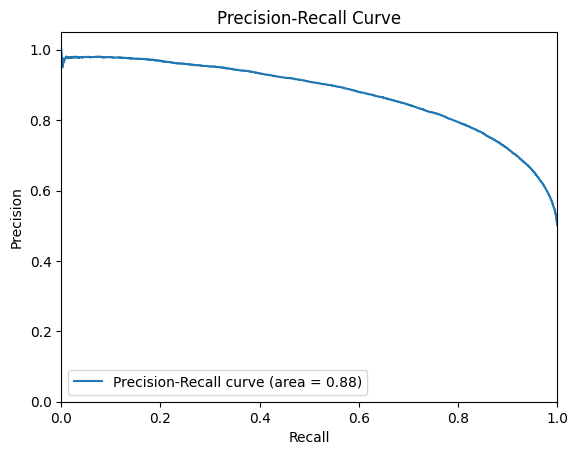

In [51]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import learning_curve


print("Best c: ", best_C)
print("Best ngram range: ", best_ngram_range)
print("Best max features: ", best_max_features)

vectoriser = TfidfVectorizer(ngram_range=best_ngram_range, max_features=best_max_features)

# Fit and transform the train set
X_train_transformed = vectoriser.fit_transform(X_train)

# Transform the validation set
X_val_transformed = vectoriser.transform(X_val)


model = LogisticRegression(max_iter=1000, n_jobs=-1, C=best_C)


model.fit(X_train_transformed, y_train)


y_val_pred = model.predict(X_val_transformed)
y_train_pred = model.predict(X_train_transformed)

# Print Accuracy Scores
print("Train Accuracy: ", accuracy_score(y_train, y_train_pred))
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred))

# Plot Learning Curve
train_sizes, train_scores, val_scores = learning_curve(model, X_train_transformed, y_train, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, val_mean, label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()



X_test_transformed = vectoriser.transform(X_test)


y_test_pred = model.predict(X_test_transformed)


print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))


cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix using seaborn's heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC curve
y_test_pred_proba = model.predict_proba(X_test_transformed)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr,label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
average_precision = average_precision_score(y_test, y_test_pred_proba)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


### Results
The model performed quite well, with an accuracy of nearly 80% on the test data. The training data has an accuracy of about 85% which alongside the results from the learning curve graph might suggest slight overfitting but I'd consider the end results to be within the acceptable bounds for what I was hoping to accomplish here. 
The Precision Recall curve suggests that the model has good precision with few false positives at lower recall values.
Similarly, the ROC curve also suggests the performance is better than random and is quite competent at distinguishing between the two classes.

### Conclusion
Overall, I am satisfied with the results of this project, I was able to create a model that can predict the sentiment of a tweet with roughly 80% accuracy. With more time and resources I feel like I could definitely improve the model further but this was a very enjoyable learning experience for figuring things out on my own. 